# WeatherPy
----

### Analysis
* As most pepole are aware, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). 
* For cities equi-distant from the equator however, the southern hemisphere is much warmer than it's northern hemisphere counter parts, given that the southern hemispehere at this time of year is in summer while the northern hemisphere is in winter. The Earths tilt is the reason why the seasons are reversed in the southern hemisphere.

* There is no strong relationship between latitude and humidity, but while we see high humidty at the equator and for cities equidistant of +/- 100 latitude, for those cities close to the equator there are no observations where the humidity is 0. 

* There are a handful of observations for cities in Russia have 0 humidity.  These are outliers in the scatter plot and I would question the validity of the humidity data point for these observations

* There is no strong relationship between latitude and cloudiness. 

* There is no strong relationship between latitude and wind speed.


In [14]:
%matplotlib inline

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "./output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [15]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

621

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [16]:
"""
Function that prints out a message banner

param1: decoration: a single char to use as the header and footer banner 
param2: message: the message to display

"""
def print_banner(decoration, message):
    print(decoration * len(message))
    print(message)
    print(decoration * len(message))

In [17]:
"""
Function to build the url by city name

param1: city_name: the cityname

returns: the fully formed url for the OpenWeatherMap API with the api_key and the city_name and units as imperial as query params
"""
def build_url_by_city_name(city_name):
    base_url = f'http://api.openweathermap.org/data/2.5/weather?appid={api_key}'
    return f"{base_url}&q={city_name}&units=imperial"

In [18]:
#Create an empty list
l = []

start_msg = 'Beginning Data Retrieval'
end_msg = 'Data Retrieval Complete'
interrupt_msg = 'Stopped processing at the request of the user'

print_banner(decoration='-', message=start_msg)

batch_size = 60
wait_time = 1
record_number = 0
record_group_number = 0

try:
    for i in range(0, len(cities), batch_size):
        record_group_number = record_group_number + 1
        print_banner(decoration='o', message=datetime.datetime.now().strftime('%m/%d/%Y %r'))
        for j in range(i, batch_size + i): 
            #sleep for 1 second per api call
            time.sleep(wait_time)                
           
            if j < len(cities):
                record_number = j + 1
                json_data = requests.get(build_url_by_city_name(cities[j])).json()
                if json_data['cod'] == '404':
                    print(f"City not found. Skipping {cities[j]} ...") 
                else:
                    print(f"Processing Record {record_number} of Set {record_group_number} | {json_data['name']}")
                    #Create an empty dictionary to store what we want from the json_data 
                    d = {}
                    d['id'] = json_data['id']
                    d['City'] = json_data['name']
                    d['Country'] = json_data['sys']['country']
                    d['Date'] = json_data['dt']
                    d['Humidity'] = json_data['main']['humidity']
                    d['Lat'] = json_data['coord']['lat']
                    d['Lng'] = json_data['coord']['lon']
                    d['Cloudiness'] = json_data['clouds']['all']
                    d['Max Temp'] = json_data['main']['temp_max']
                    d['Wind Speed'] = json_data['wind']['speed']
                    l.append(d)

except KeyboardInterrupt:
    print_banner(decoration='*', message=interrupt_msg)
except KeyError:
    if type(json_data) == dict:
        print(f"ERROR: {json_data['cod']}: {json_data['message']}")
    else:
        print('Something went wrong')
finally:  
    print_banner(decoration='-', message=end_msg)
    print_banner(decoration='o', message=datetime.datetime.now().strftime('%m/%d/%Y %r'))

------------------------
Beginning Data Retrieval
------------------------
oooooooooooooooooooooo
12/05/2018 02:05:55 PM
oooooooooooooooooooooo
Processing Record 1 of Set 1 | Yantal
Processing Record 2 of Set 1 | Cape Town
Processing Record 3 of Set 1 | Kodiak
Processing Record 4 of Set 1 | Rengasdengklok
Processing Record 5 of Set 1 | Punta Arenas
Processing Record 6 of Set 1 | Rikitea
Processing Record 7 of Set 1 | Tautira
City not found. Skipping belushya guba ...
Processing Record 9 of Set 1 | Saint Anthony
Processing Record 10 of Set 1 | Longyearbyen
Processing Record 11 of Set 1 | Ketchikan
Processing Record 12 of Set 1 | Teguldet
Processing Record 13 of Set 1 | Chuy
Processing Record 14 of Set 1 | Albany
Processing Record 15 of Set 1 | Port Alfred
City not found. Skipping mys shmidta ...
Processing Record 17 of Set 1 | Tasiilaq
Processing Record 18 of Set 1 | Bethel
Processing Record 19 of Set 1 | Piney Green
Processing Record 20 of Set 1 | Vaini
Processing Record 21 of Set 1 | 

Processing Record 192 of Set 4 | Maunabo
Processing Record 193 of Set 4 | Saint-Brieuc
Processing Record 194 of Set 4 | Mulege
Processing Record 195 of Set 4 | Ambanja
Processing Record 196 of Set 4 | Jalu
Processing Record 197 of Set 4 | Qasigiannguit
Processing Record 198 of Set 4 | Luderitz
Processing Record 199 of Set 4 | Ambam
Processing Record 200 of Set 4 | Sitka
Processing Record 201 of Set 4 | Narsaq
Processing Record 202 of Set 4 | Comodoro Rivadavia
Processing Record 203 of Set 4 | Kaoma
Processing Record 204 of Set 4 | Port-Cartier
Processing Record 205 of Set 4 | Mopti
Processing Record 206 of Set 4 | Sistranda
Processing Record 207 of Set 4 | Husavik
City not found. Skipping vaitupu ...
City not found. Skipping taolanaro ...
Processing Record 210 of Set 4 | Kirakira
Processing Record 211 of Set 4 | Fukue
Processing Record 212 of Set 4 | Tiksi
Processing Record 213 of Set 4 | Yar-Sale
Processing Record 214 of Set 4 | Kavaratti
Processing Record 215 of Set 4 | Baie-Comeau
P

Processing Record 382 of Set 7 | Constitucion
City not found. Skipping ndende ...
Processing Record 384 of Set 7 | Kantunilkin
Processing Record 385 of Set 7 | Kirkenaer
Processing Record 386 of Set 7 | Carnarvon
Processing Record 387 of Set 7 | Isla Mujeres
Processing Record 388 of Set 7 | Estevan
Processing Record 389 of Set 7 | Klaksvik
City not found. Skipping crab hill ...
Processing Record 391 of Set 7 | Kailua
City not found. Skipping satitoa ...
Processing Record 393 of Set 7 | Ribeira Grande
Processing Record 394 of Set 7 | Mount Gambier
Processing Record 395 of Set 7 | Umm Lajj
Processing Record 396 of Set 7 | Benalla
Processing Record 397 of Set 7 | Naliya
Processing Record 398 of Set 7 | Manta
City not found. Skipping asfi ...
City not found. Skipping samalaeulu ...
Processing Record 401 of Set 7 | Kharp
Processing Record 402 of Set 7 | Hvide Sande
Processing Record 403 of Set 7 | Urusha
Processing Record 404 of Set 7 | Chichibu
Processing Record 405 of Set 7 | Gorontalo
Pr

Processing Record 572 of Set 10 | Benghazi
Processing Record 573 of Set 10 | Kondagaon
Processing Record 574 of Set 10 | Altay
Processing Record 575 of Set 10 | Bintulu
Processing Record 576 of Set 10 | Lima
Processing Record 577 of Set 10 | Omsukchan
Processing Record 578 of Set 10 | Vestmannaeyjar
Processing Record 579 of Set 10 | Pochutla
Processing Record 580 of Set 10 | Gamboma
Processing Record 581 of Set 10 | Mananjary
Processing Record 582 of Set 10 | Salinas
Processing Record 583 of Set 10 | Gallatin
Processing Record 584 of Set 10 | Elena
Processing Record 585 of Set 10 | Laguna
Processing Record 586 of Set 10 | Cordele
Processing Record 587 of Set 10 | Kyabe
Processing Record 588 of Set 10 | Lakes Entrance
Processing Record 589 of Set 10 | Mugur-Aksy
City not found. Skipping sumbawa ...
Processing Record 591 of Set 10 | Goundi
Processing Record 592 of Set 10 | Tecpan
Processing Record 593 of Set 10 | Son La
Processing Record 594 of Set 10 | Freeport
Processing Record 595 of 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [19]:
df = pd.DataFrame(l)
df.to_csv(output_data_file, index=False)
#df = pd.read_csv(output_data_file)
df.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,id
0,Yantal,48,RU,1544047556,39,56.85,105.25,-26.40,3.27,2055868
1,Cape Town,0,ZA,1544043600,88,-33.93,18.42,64.40,8.05,3369157
2,Kodiak,1,US,1544044500,38,39.95,-94.76,44.96,8.05,4407665
3,Rengasdengklok,36,ID,1544047560,100,-6.16,107.30,77.78,4.16,1629710
4,Punta Arenas,75,CL,1544043600,71,-53.16,-70.91,53.60,16.11,3874787


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [20]:
"""
Function to build the scatter plot based on the param values passed in

param1: x_axis
param2: y_axis
param3: title
param4: xlabel
param5. ylabel

"""
def build_scatter_plot(x_axis, y_axis, title, xlabel, ylabel):
    todays_date = datetime.date.today().strftime('%m/%d/%Y')
    plt.scatter(x=x_axis, y=y_axis, alpha=.75, edgecolors='black', linewidths=.75)
    plt.title(f"{title} ({todays_date})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

#### Latitude vs. Temperature Plot

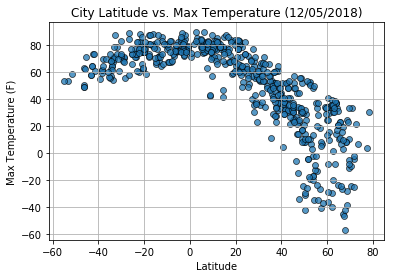

In [21]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Max Temp']
                   , title='City Latitude vs. Max Temperature'
                   , xlabel='Latitude'
                   , ylabel='Max Temperature (F)'
                  )  

# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_max_temperature.png")

# Show Figure
plt.show()

#### Latitude vs. Humidity Plot

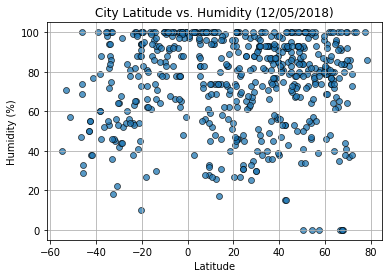

In [22]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Humidity']
                   , title='City Latitude vs. Humidity'
                   , xlabel='Latitude'
                   , ylabel='Humidity (%)'
                  )
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_humidity.png")

# Show Figure
plt.show()

#### Latitude vs. Cloudiness Plot

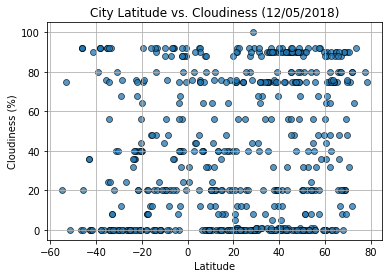

In [23]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Cloudiness']
                   , title='City Latitude vs. Cloudiness'
                   , xlabel='Latitude'
                   , ylabel='Cloudiness (%)'
                  ) 
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_cloudiness.png")

# Show Figure
plt.show()

#### Latitude vs. Wind Speed Plot

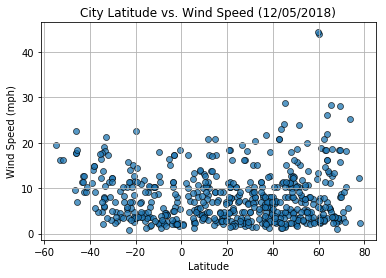

In [24]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Wind Speed']
                   , title='City Latitude vs. Wind Speed'
                   , xlabel='Latitude'
                   , ylabel='Wind Speed (mph)'
                  )  
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_wind_speed.png")

# Show Figure
plt.show()

## Data supporting observations and trends

#### for those cities close to the equator there are no observations where the humidity is 0

In [25]:
df[(df['Lat'] >= -2) & (df['Lat'] <= 2)]

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,id
54,Hithadhoo,88,MV,1544047631,100,-0.60,73.08,79.22,5.39,1282256
57,Puerto Ayora,75,EC,1544043600,57,-0.74,-90.35,78.80,18.34,3652764
84,Biak,20,ID,1544047675,100,-0.91,122.88,77.87,1.59,1637001
292,Padang,92,ID,1544047977,100,-0.92,100.36,75.80,2.26,1633419
300,Makokou,32,GA,1544047991,97,0.56,12.85,71.25,2.15,2399371
359,Gorontalo,24,ID,1544048077,98,0.54,123.06,74.04,1.92,1643837
418,Cururupu,88,BR,1544048158,97,-1.82,-44.87,76.43,2.15,3401148
524,Gamboma,24,CG,1544048298,88,-1.87,15.88,74.67,2.15,2259947


#### There are a handful of observations for cities in Russia have 0 humidity
* these are outliers in the scatter plot and I would question the validity of the humidity data point.

In [26]:
df[(df['Humidity'] == 0) & (df['Country'] <= 'RU') & (df['Lat'] >= 60)]

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,id
39,Zhigansk,12,RU,1544047317,0,66.77,123.37,-45.08,3.15,2012530
86,Batagay,8,RU,1544047677,0,67.65,134.64,-56.73,2.82,2027044
215,Batagay-Alyta,0,RU,1544047871,0,67.80,130.41,-41.84,0.92,2027042
398,Verkhoyansk,20,RU,1544048132,0,67.55,133.39,-46.65,2.26,2013465
